# HousePricePrediction

In [263]:
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.model_selection import GridSearchCV

pd.set_option('max_rows', 10, 'max_columns', 50)
%matplotlib inline

### Dataset
- ID : 집을 구분하는 번호
- date : 집을 구매한 날짜
- price : 집의 가격(Target variable)
- bedrooms : 침실의 수
- bathrooms : 침실 개수 당 화장실의 수(화장실의 수 / 침실의 수 )
- sqft_living : 주거 공간의 평방 피트(면적)
- sqft_lot : 부지의 평방 피트(면적)
- floors : 집의 층 수
- waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
- view : 집이 얼마나 좋아 보이는지의 정도
- condition : 집의 전반적인 상태
- grade : King County grading 시스템 기준으로 매긴 집의 등급
- sqft_above : 지하실을 제외한 평방 피트(면적)
- sqft_basement : 지하실의 평방 피트(면적)
- yr_built : 지어진 년도
- yr_renovated : 집을 재건축한 년도
- zipcode : 우편번호
- lat : 위도
- long : 경도
- sqft_living15 : 2015년 기준 주거 공간의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)
- sqft_lot15 : 2015년 기준 부지의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)

In [149]:
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
test_id = df_test['id']

In [150]:
print("train set 데이터량", df.shape)
print("test set 데이터량", df_test.shape)

train set 데이터량 (15035, 21)
test set 데이터량 (6468, 20)


### EDA & Preprocessing

#### Null Data 확인
- 다음 정보를 통해 train data와 test data에 Null 값이 없는 것을 확인 할 수 있습니다. 하지만, Null data는 없을 지라도 다른 결측치가 있을 수 있다는 것은 염두해 두어야 합니다. 
- 추후에 feature 별로 자세히 살펴볼 때, Null 이 아닌 다른 결측치가 있을지 확인해 보아야 합니다.

In [151]:
print("Train set 데이터 정보: \n", df.info())
print('------------\n')
print("Test set 데이터 정보: \n", df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 21 columns):
id               15035 non-null int64
date             15035 non-null object
price            15035 non-null float64
bedrooms         15035 non-null int64
bathrooms        15035 non-null float64
sqft_living      15035 non-null int64
sqft_lot         15035 non-null int64
floors           15035 non-null float64
waterfront       15035 non-null int64
view             15035 non-null int64
condition        15035 non-null int64
grade            15035 non-null int64
sqft_above       15035 non-null int64
sqft_basement    15035 non-null int64
yr_built         15035 non-null int64
yr_renovated     15035 non-null int64
zipcode          15035 non-null int64
lat              15035 non-null float64
long             15035 non-null float64
sqft_living15    15035 non-null int64
sqft_lot15       15035 non-null int64
dtypes: float64(5), int64(15), object(1)
memory usage: 2.4+ MB
Train set 데이터 정보: 


#### `price` : target 분포 확인 및 전처리
- target value 의 분포가 정규분포와는 거리가 멉니다.
- skewness 가 0보다 큼을 분포 모양이 왼쪽으로 치우쳐져 있는 형태를 통해서도 확인할 수 있으며, 수치들을 통해서도 확인할 수 있습니다.
- kurtosis 역시 매우 뾰족한 분포 모양을 통해서도 알 수 있고, 그 수치가 나타남을 확인 할 수 있습니다.

skewness:  4.290252396939529
kurtosis: 40.15491919350329


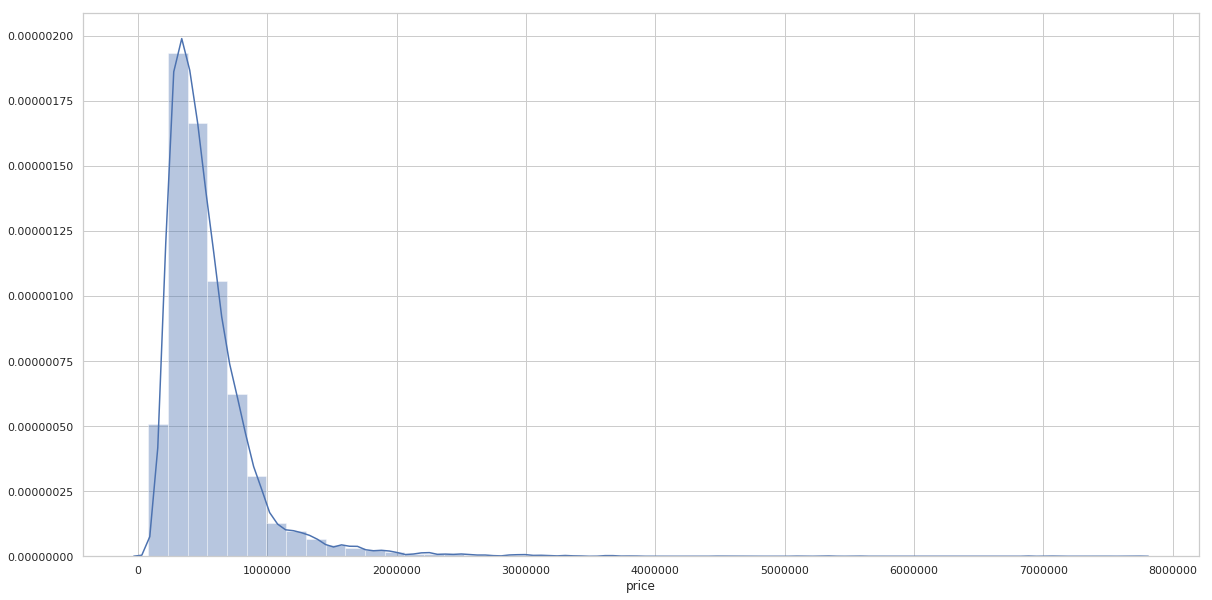

In [152]:
print("skewness: ", df['price'].skew())
print("kurtosis:", df['price'].kurt())
plt.figure(figsize=(20, 10))
sns.distplot(df['price'])

- `price` 분포를 좀더 정규화 해주기 위해, logarithm 을 취해줍니다. 꼭 잊지말고, 최종 예측치에서는 exponential 을 취해주어야 합니다.

In [153]:
original_price = df['price'] # save original price 
df['price'] = np.log1p(df['price'])

### `id` drop
- id 의 경우 prediction 에 영향이 없으므로, drop 해 주겠습니다.

In [154]:
df = df.drop('id', axis=1)
df_test = df_test.drop('id', axis=1)

#### `date` : 형식 확인 및 전처리
- `Date` Column 이 모두 **날짜(숫자 8자리) + T000000** pattern 으로 되어있는지 확인해봅니다.
    - 확인결과, 모두 숫자, T000000 형태가 붙어있는 것을 확인 할 수 있습니다. (True)

In [155]:
def regex(data):
    pattern = re.compile('^[0-9]{8}T000000$')
    match = pattern.match(data)
    if match:
        return True
    else:
        return False
    
date_pattern_check_series = df['date'].apply(lambda data: regex(data))
print(all(date_pattern_check_series))
del date_pattern_check_series

True


- 모두 같은 형태임을 확인했으므로, 날짜형식만자리까지만 자신있게 제거해줍니다.

In [156]:
df['date'] = df['date'].apply(lambda data: data[:8])
df_test['date'] = df_test['date'].apply(lambda data: data[:8])

- `date`를 활용해 매달 주택의 거래량과 그 평균 price 를 확인해 보겠습니다.
    - 거래량이 많은 달에는 평균 가격이 비교적 높은 것을 확인 할 수 있습니다.
    - 2015년 05월에는 거래량이 다른 다른달에 비해 많지 않은데도 불구하고, 평균 가격이 높은 특이점도 확인 할 수 있습니다.
    - 시계열 적인 데이터의 수가 많지 않고, 부족하기 때문에, 월별 주기성을 확정 할 수 는 없지만 `date` column 을 drop 하고, yearmonth data 를 dummy 변수로 활용하겠습니다.

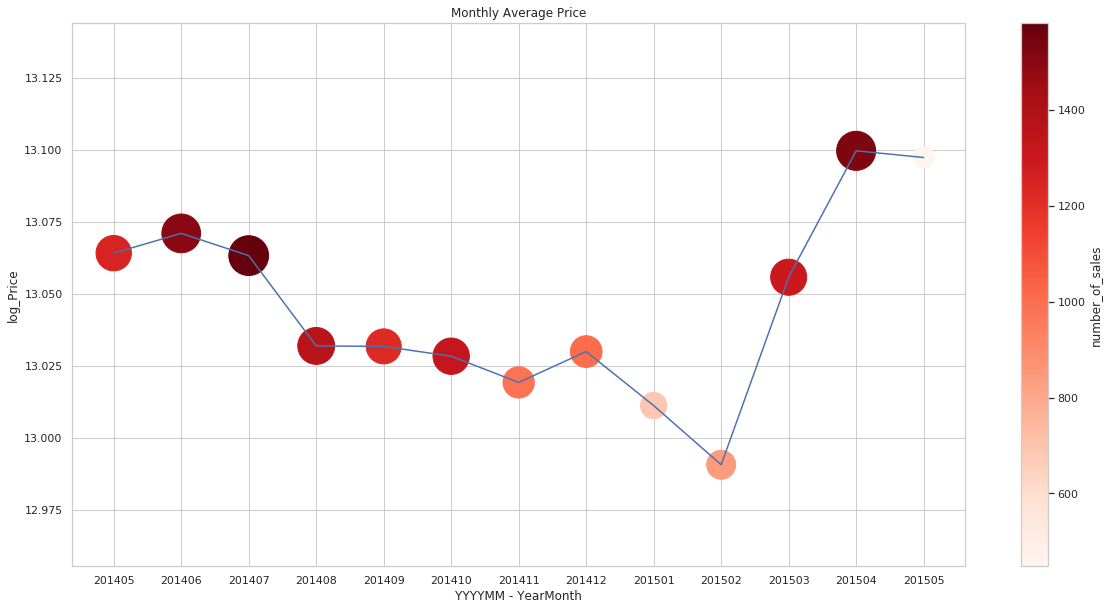

In [157]:
df['yrmth'] = df['date'].apply(lambda data: data[:6])
df_test['yrmth'] = df_test['date'].apply(lambda data: data[:6])

yrmth_df = df.groupby('yrmth')['price'].agg({'mean_price': 'mean', 
                                             'number_of_sales': 'count'})
vmin = np.min(yrmth_df['number_of_sales'])
vmax = np.max(yrmth_df['number_of_sales'])

plt.figure(figsize=(20, 10))

plt.scatter(np.arange(yrmth_df.shape[0]), yrmth_df['mean_price'], c=yrmth_df['number_of_sales'], \
            s=yrmth_df['number_of_sales'], vmin=vmin, vmax=vmax, cmap=plt.cm.Reds)
plt.colorbar(label='number_of_sales')

plt.plot(np.arange(yrmth_df.shape[0]), yrmth_df['mean_price'])

plt.title('Monthly Average Price')
plt.xticks(np.arange(yrmth_df.shape[0]), yrmth_df.index.values)
plt.xlabel('YYYYMM - YearMonth')
plt.ylabel('log_Price')
plt.show()

In [158]:
df = pd.get_dummies(df, columns=['yrmth'], drop_first=True)
df_test = pd.get_dummies(df_test, columns=['yrmth'], drop_first=True)

# df = df.drop('date', axis=1)
# df_test = df_test.drop('date', axis=1)

In [159]:
df['date'] = df['date'].apply(lambda data: int(data))
df_test['date'] = df_test['date'].apply(lambda data: int(data))

### `sqft_living`, `sqft_living15`,  `sqft_basement`, `sqft_above`, `sqft_lot`, `sqft_lot15`
- `sqft_living`, `sqft_basement`, `sqft_above` 간의 관계를 확인해 봅니다.
    - 확인결과, `sqft_living`은 `sqft_basement` 와 `sqft_above`를 더한 값임을 확인 할 수 있습니다.
    - 독립변수간에 상관성이 매우 높을 것이 예상되므로, `sqft_basement`는 지하실이 있는지 유무로 categorical variable 로 바꿔주고, drop하겠습니다.

In [160]:
all(df['sqft_living'] == (df['sqft_basement'] + df['sqft_above']))

True

- Correlation 확인을 해보겠습니다.
    - sqft_living15 와 sqft_lot15 의 경우, 각각 sqft_livng 과 sqft_lot 간에 correlation 이 매우 높은 것을 확인 할 수 있습니다.
    - `sqft_living15`와 `sqft_lot15`를 drop 해 주겠습니다.
    - 또한 위에서 `sqft_basement`와 `sqft_above` 를 더한 값이 `sqft_living`과 같으므로 `basement`는 더미변수로, `sqft_above`는 삭제해주겠습니다.

In [161]:
df[['sqft_living', 'sqft_living15', 'sqft_basement', 'sqft_above', 'sqft_lot', 'sqft_lot15', 'price']].corr()

,sqft_living,sqft_living15,sqft_basement,sqft_above,sqft_lot,sqft_lot15,price
sqft_living,1.000000,0.760271,0.434017,0.878736,0.176500,0.184176,0.697907
sqft_living15,0.760271,1.000000,0.198380,0.737795,0.147562,0.183599,0.621800
sqft_basement,0.434017,0.198380,1.000000,-0.048623,0.017818,0.018813,0.314378
sqft_above,0.878736,0.737795,-0.048623,1.000000,0.186242,0.194226,0.607197
sqft_lot,0.176500,0.147562,0.017818,0.186242,1.000000,0.728458,0.108946
sqft_lot15,0.184176,0.183599,0.018813,0.194226,0.728458,1.000000,0.096976
price,0.697907,0.621800,0.314378,0.607197,0.108946,0.096976,1.000000


In [162]:
# sqft_basement 를 dummy 변수로 만들어주는 코드
pre_sqft_df = df.copy()
pre_sqft_df['basement_dummy'] = pre_sqft_df['sqft_basement'].apply(lambda data: 1 if data > 0 else 0)
df_test['basement_dummy'] = df_test['sqft_basement'].apply(lambda data: 1 if data > 0 else 0)

# pre_sqft_df = pre_sqft_df.drop('sqft_basement', axis=1)
# df_test = df_test.drop('sqft_basement', axis=1)
# pre_sqft_df.head()

In [163]:
# sqft_living15 와 sqft_lot15, sqft_above drop 코드
pre_sqft_df = pre_sqft_df.drop(columns=['sqft_living15', 'sqft_lot15', 'sqft_above'], axis=1)
df_test = df_test.drop(columns=['sqft_living15', 'sqft_lot15', 'sqft_above'], axis=1)

- `sqft_living`, `sqft_basement`, `sqft_lot`,의 skewness를 확인합니다.
    - skewness 가 비교적 큰 것 (저의 경우 그 기준을 1로 하였습니다.) 1보다 큰 skewness 를 logarithm 을 취해줍니다.

In [164]:
print("sqft_living skewness: ", pre_sqft_df['sqft_living'].skew())
print("sqft_basement skewness: ", pre_sqft_df['sqft_basement'].skew())
print("sqft_lot skewness: ", pre_sqft_df['sqft_lot'].skew())

sqft_living skewness:  1.4924715984991939
sqft_basement skewness:  1.5565549481889323
sqft_lot skewness:  13.35050013446013


In [165]:
skew_list = ['sqft_living', 'sqft_basement', 'sqft_lot',]
for skew in skew_list:
    pre_sqft_df[skew] = pre_sqft_df[skew].apply(lambda data: np.log1p(data))
    df_test[skew] = df_test[skew].apply(lambda data: np.log1p(data))

In [166]:
print("sqft_living skewness: ", pre_sqft_df['sqft_living'].skew())
print("sqft_basement skewness: ", pre_sqft_df['sqft_basement'].skew())
print("sqft_lot skewness: ", pre_sqft_df['sqft_lot'].skew())

sqft_living skewness:  -0.03745962412709876
sqft_basement skewness:  0.4884019504032108
sqft_lot skewness:  0.9899185058491824


### `yr_built` & `yr_renovated`
- `yr_built`와 `yr_renovated`의 경우 집의 건축연도, 재건축 연도를 의미합니다. yr_renovated 의 경우, 리모델링이 되지 않았을 때는 0으로 처리 되는 것을 볼 수 있습니다.
- 우리의 경험칙상 집이 재건축이 되면, 재건축된 연도가 처음 건축된 연도보다 더 중요했음을 알 수 있습니다.
    - 따라서 yr_renovated 의 경우 리모델링을 했는지 안했는지로 변수를 바꿔주도록 하겠습니다. 또한 두 변수를 조합한 yr_combine 형태의 컬럼역시 만들어 주도록 하겠습니다.

In [167]:
pre_sqft_built_df = pre_sqft_df.copy()

In [168]:
pre_sqft_built_df['yr_built'].unique()

array([1955, 1933, 1987, 1995, 1963, 1965, 1942, 1927, 1977, 1900, 1979,
       1994, 1916, 1921, 1969, 1947, 1968, 1985, 1941, 1915, 1909, 2003,
       1929, 1981, 1930, 1904, 1996, 1984, 2014, 1922, 1966, 1950, 2008,
       1959, 1954, 1989, 2005, 1973, 1972, 1986, 1956, 2002, 1992, 1964,
       1952, 1925, 1961, 2006, 1988, 2001, 1962, 1939, 1967, 1975, 1910,
       1983, 1991, 1905, 1980, 1971, 2010, 1945, 1924, 1978, 1926, 1923,
       1990, 2000, 1976, 1949, 1999, 1901, 1993, 1948, 1920, 1997, 1957,
       2004, 1960, 1940, 1918, 1974, 1911, 1937, 1982, 1908, 1931, 1998,
       1928, 1943, 1907, 2013, 1953, 2012, 2007, 1912, 2011, 1917, 1958,
       1946, 1951, 1932, 1944, 2009, 1903, 1970, 1938, 1919, 1906, 1936,
       1913, 1902, 1914, 2015, 1935, 1934])

In [169]:
pre_sqft_built_df['yr_renovated'].unique()

array([   0, 2002, 1999, 1991, 1978, 2005, 2008, 2003, 1994, 1984, 1954,
       2014, 2011, 1974, 1983, 2013, 1990, 1957, 1977, 1981, 1995, 2000,
       1986, 1992, 2004, 2007, 1987, 2006, 1985, 1971, 1945, 1979, 1997,
       2010, 1969, 1948, 2009, 1970, 2015, 1989, 2001, 1968, 2012, 1963,
       1993, 1962, 1972, 1980, 1998, 1955, 1996, 1950, 1956, 1982, 1988,
       1940, 1946, 1975, 1964, 1958, 1976, 1973, 1967, 1965, 1944])

- 앞서, null 값이 없다고 생각했었지만, yr_renovated 의 경우 대부분의 값들이 0값임을 알수 있다. 
- 이는 애초에 재건축이 되지 않았거나, 혹은 재건축이 되었더라도, 기록을 못했기때문에 일어난 일이라고 생각하는 것이 일감이지만, 좀더 살펴볼 필요가 있다.

In [170]:
pre_sqft_built_df['yr_renovated'].value_counts().head()

0       14404
2014       71
2013       28
2003       25
2007       25
Name: yr_renovated, dtype: int64

- 경험칙상, 재건축을 하게 되면 지어진 날짜보다는 재건축된 날짜가 아파트의 연식을 계산하는데 더 주요한 변수가 됩니다.
    - 따라서, yr_renovated 와 yr_built 를 합치는 새로운 column 을 생각해 볼 수 있다.
    - 재건축을 하지 않아, yr_renovated 의 값이 0 인 경우, yr_built 를 가져오고,
    - 재건축을 한 경우에는 yr_renovated 의 값을 가져오는 column 을 생성해보는 것이다.

In [171]:
pre_sqft_built_df['renovated_index'] = pre_sqft_built_df['yr_renovated'].apply(lambda data: 0 if data == 0 else 1)
df_test['renovated_index'] = df_test['yr_renovated'].apply(lambda data: 0 if data == 0 else 1)
pre_sqft_built_df['yr_combine'] = pre_sqft_built_df.apply(lambda df: max(df['yr_built'], df['yr_renovated']), axis=1)
df_test['yr_combine'] = df_test.apply(lambda df: max(df['yr_built'], df['yr_renovated']), axis=1)

- yr_built 와 yr_comibne 의 경우, correlation 이 매우 높으므로, yr_built 을 삭제해주도록 하겠습니다.

In [172]:
pre_sqft_built_df[['yr_built', 'yr_renovated', 'yr_combine', 'price']].corr()

,yr_built,yr_renovated,yr_combine,price
yr_built,1.000000,-0.215760,0.911773,0.076293
yr_renovated,-0.215760,1.000000,0.169203,0.127533
yr_combine,0.911773,0.169203,1.000000,0.128711
price,0.076293,0.127533,0.128711,1.000000


In [173]:
# yr_built 삭제
pre_sqft_built_df = pre_sqft_built_df.drop('yr_built', axis=1)
df_test = df_test.drop('yr_built', axis=1)

In [174]:
pre_sqft_built_df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_basement,yr_renovated,zipcode,lat,long,yrmth_201406,yrmth_201407,yrmth_201408,yrmth_201409,yrmth_201410,yrmth_201411,yrmth_201412,yrmth_201501,yrmth_201502,yrmth_201503,yrmth_201504,yrmth_201505,basement_dummy,renovated_index,yr_combine
0,20141013,12.309987,3,1.00,7.074117,8.639588,1.0,0,0,3,7,0.0,0,98178,47.5112,-122.257,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1955.0
1,20150225,12.100718,2,1.00,6.647688,9.210440,1.0,0,0,3,6,0.0,0,98028,47.7379,-122.233,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1933.0
2,20150218,13.142168,3,2.00,7.427144,8.997271,1.0,0,0,3,8,0.0,0,98074,47.6168,-122.045,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1987.0
3,20140627,12.458779,3,2.25,7.447751,8.827615,2.0,0,0,3,7,0.0,0,98003,47.3097,-122.327,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1995.0
4,20150115,12.583999,3,1.50,6.966967,9.181118,1.0,0,0,3,7,0.0,0,98198,47.4095,-122.315,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1963.0


### `waterfront`
- waterfront 는 집의 전방에 물이 흐르는지 유무에 관한 feature 입니다.
- waterfront 에 따른 price 의 분포를 확인 해봄으로써, waterfront 의 중요도를 짐작해보겠습니다.
    -  아래 그림을 살펴 보면, waterfront 에 따른 분포가 확연히 다른 것을 확인 할 수 있습니다. 이 feature 는 그대로 두어도 될것 같습니다.

In [175]:
pre_sqft_built_df['waterfront'].unique()

array([0, 1])

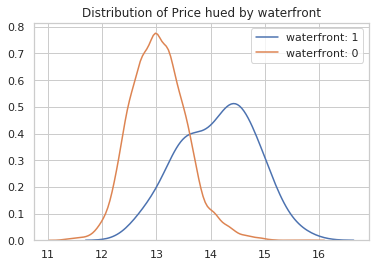

In [176]:
plt.title("Distribution of Price hued by waterfront")
sns.kdeplot(pre_sqft_built_df[pre_sqft_built_df['waterfront']==1]['price'])
sns.kdeplot(pre_sqft_built_df[pre_sqft_built_df['waterfront']==0]['price'])
plt.legend(['waterfront: 1', 'waterfront: 0'])
plt.show()

## `'bedrooms', 'bathrooms', 'floors', 'view', 'condition', 'grade'`
- 6개의 변수들을 살펴보겠습니다.
- 아래 그림을 보면, floors 의 경우 floors 의 숫자가 증가함에 따라 price 의 증가가 선명하지 않습니다.
    - 따라서 floors 를 category vaiable 로 주어, 각 case 에 대한 모델링을 따로 하는 것이 좋을 것 같습니다.

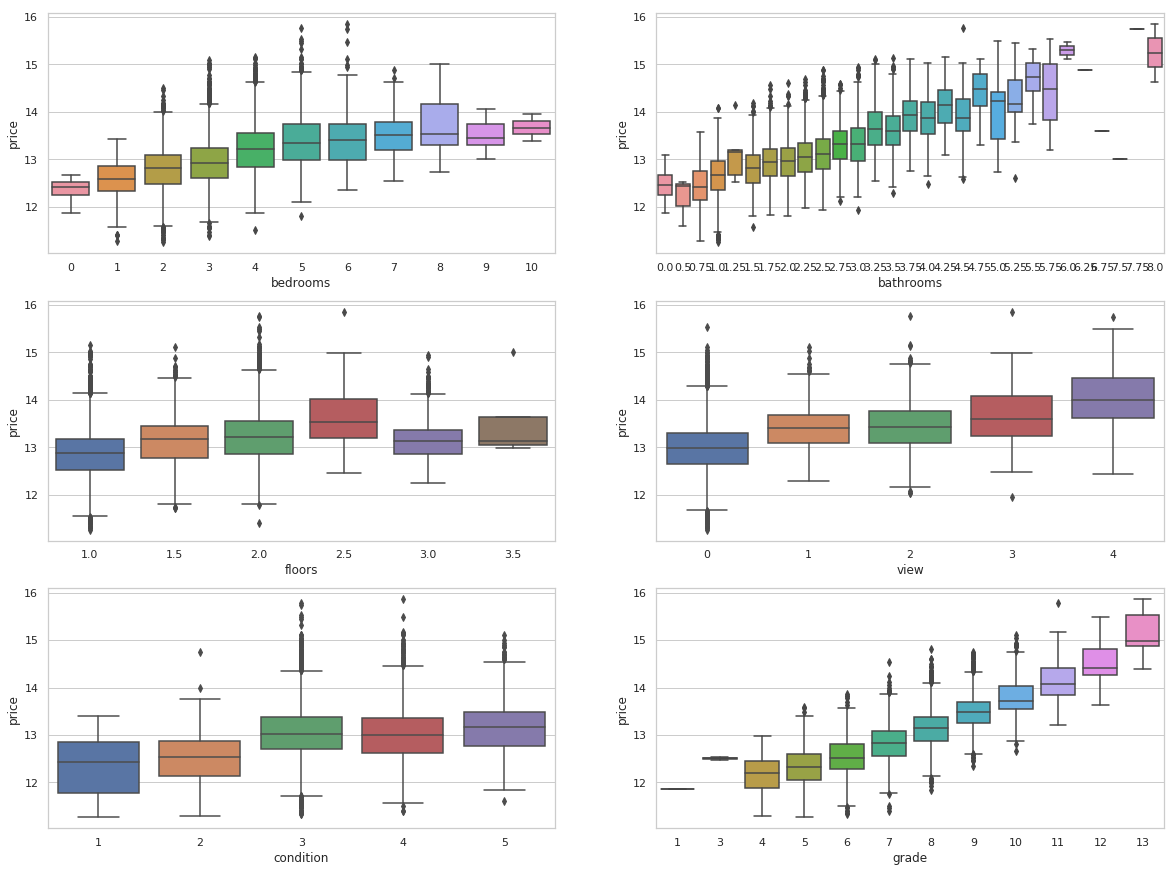

In [177]:
others = ['bedrooms', 'bathrooms', 'floors', 'view', 'condition', 'grade']
plt.figure(figsize=(20, 15))
for index, item in enumerate(others):
    plt.subplot(321+index)
    sns.boxplot(x=item, y='price', data=pre_sqft_built_df)

In [178]:
pre_sqft_built_df = pd.get_dummies(pre_sqft_built_df, columns=['floors'], drop_first=True)
df_test = pd.get_dummies(df_test, columns=['floors'], drop_first=True)

In [251]:
y_label = pre_sqft_df['price']
X_data = pre_sqft_df.drop('price', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_data, y_label, test_size=0.2, random_state=20190319)

In [260]:
def scoring(models, X_train, y_train, X_test, y_test):
    exponential_test = np.expm1(y_test)
    for model in models:
        fitted = model.fit(X_train, y_train)
        y_pred = fitted.predict(X_test)
        rmsle = np.sqrt(mean_squared_error(y_test, y_pred))
        y_pred = np.expm1(y_pred)
        rmse = np.sqrt(mean_squared_error(exponential_test, y_pred))
        print("{}, rmsle: {}".format(model.__class__.__name__, rmsle))
        print("{}, rmse: {}".format(model.__class__.__name__, rmse))

In [261]:
lr = LinearRegression()
rd = Ridge()
ls = Lasso()
el = ElasticNet()
xgb = XGBRegressor()
lgbm = LGBMRegressor()

models = [lr, rd, ls, el, xgb, lgbm]
scoring(models, X_train, y_train, X_test, y_test)

LinearRegression, rmsle: 0.2544227801090251
LinearRegression, rmse: 191479.38950250513
Ridge, rmsle: 0.25448995919437656
Ridge, rmse: 191602.04912273196
Lasso, rmsle: 0.5218942152071568
Lasso, rmse: 401679.65988760744
ElasticNet, rmsle: 0.5209829040562096
ElasticNet, rmse: 401338.685232563
XGBRegressor, rmsle: 0.18438147539048225
XGBRegressor, rmse: 169937.8729369069
LGBMRegressor, rmsle: 0.16424871077323672
LGBMRegressor, rmse: 147321.89755162294


In [265]:
from lightgbm import LGBMRegressor

lgbm = LGBMRegressor()

parameters = {
    'max_depth': [3, 7],
    'n_estimators': [100, 500, 1000],
    'learning_rate': [0.03, 0.05, 0.07, 0.1],
    'colsample_bytree': [0.5, 0.7],
    'subsample': [0.5, 0.7, 0.8],
    'min_child_weight': [0.001, 0.1, 1],
    'num_leaves': [20, 30, 40]
    
}
lgbm_grid = GridSearchCV(lgbm, parameters, scoring='neg_mean_squared_error', cv=5, n_jobs=5, verbose=5)
lgbm_grid.fit(X_train, y_train)

print(lgbm_grid.best_score_)
print(lgbm_grid.best_params_)

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:    4.1s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:   14.7s
[Parallel(n_jobs=5)]: Done 278 tasks      | elapsed:   28.5s
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:   44.8s
[Parallel(n_jobs=5)]: Done 638 tasks      | elapsed:  1.7min
[Parallel(n_jobs=5)]: Done 872 tasks      | elapsed:  2.8min
[Parallel(n_jobs=5)]: Done 1142 tasks      | elapsed:  3.3min
[Parallel(n_jobs=5)]: Done 1448 tasks      | elapsed:  4.5min
[Parallel(n_jobs=5)]: Done 1790 tasks      | elapsed:  5.8min
[Parallel(n_jobs=5)]: Done 2168 tasks      | elapsed:  6.9min
[Parallel(n_jobs=5)]: Done 2582 tasks      | elapsed:  8.4min
[Parallel(n_jobs=5)]: Done 3032 tasks      | elapsed:  9.6min
[Parallel(n_jobs=5)]: Done 3518 tasks      | elapsed: 11.3min
[Parallel(n_jobs=5)]: Done 4040 tasks      | elapsed: 13.7min
[P

-0.025731015934073117
{'colsample_bytree': 0.5, 'learning_rate': 0.03, 'max_depth': 7, 'min_child_weight': 0.001, 'n_estimators': 1000, 'num_leaves': 30, 'subsample': 0.5}


In [268]:
xgb = XGBRegressor(colsample_bytree=0.5, learning_rate=0.03, max_depth=7, min_child_weight=0.001, n_estimators=1000,\
                  num_leaves=30, subsample=0.5)
lgbm = LGBMRegressor(colsample_bytree=0.5, learning_rate=0.03, max_depth=7, min_child_weight=0.001, n_estimators=1000,\
                  num_leaves=30, subsample=0.5)
models = [xgb, lgbm]
scoring(models, X_train, y_train, X_test, y_test)

XGBRegressor, rmsle: 0.15942287754164197
XGBRegressor, rmse: 142300.1961776262
LGBMRegressor, rmsle: 0.15815220206966565
LGBMRegressor, rmse: 142120.19559094598


In [87]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

xgb = XGBRegressor()

parameters = {
    'max_depth': [3, 7],
    'n_estimators': [500, 1000],
    'learning_rate': [0.03, 0.05, 0.07, 0.1],
    'colsample_bytree': [0.5, 0.7],
    'subsample': [0.5, 0.7, 0.8],
    'min_child_weight': [1, 5]
    
}
xgb_grid = GridSearchCV(xgb, parameters, cv=5, n_jobs=5, verbose=5)
xgb_grid.fit(X_train, y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 5 folds for each of 192 candidates, totalling 960 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   56.2s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  6.3min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed: 16.1min
[Parallel(n_jobs=5)]: Done 790 tasks      | elapsed: 31.2min
[Parallel(n_jobs=5)]: Done 960 out of 960 | elapsed: 39.9min finished


0.9082011762931045
{'colsample_bytree': 0.5, 'learning_rate': 0.03, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 1000, 'subsample': 0.7}


In [108]:
xgb = XGBRegressor(colsample_bytree=0.5, learning_rate=0.03, max_depth=7, min_child_weight=1, \
                   n_estimators=1000, subsample=0.7)
xgb.fit(X_data, y_label)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=0, learning_rate=0.03, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.7)

In [180]:
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.07, colsample_bytree=0.7, subsample=0.8)
xgb_reg.fit(X_data, y_label)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0, learning_rate=0.07, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8)

In [181]:
#
xgb_predict = xgb_reg.predict(df_test)
xgb_predict = np.expm1(xgb_predict)

submission = pd.DataFrame({'id': test_id,
                          'price': xgb_predict})
submission.head()

,id,price
0,15035,5.547912e+05
1,15036,4.536362e+05
2,15037,1.439972e+06
3,15038,3.211153e+05
4,15039,3.203030e+05


In [94]:
# y_pred = xgb.predict(X_test)

# rmsle = np.sqrt(mean_squared_error(y_test, y_pred))

# y_pred = np.expm1(y_pred)
# y_test = np.expm1(y_test)

# rmse = np.sqrt(mean_squared_error(y_test, y_pred))
# print("rmsle", rmsle)
# print("rmse", rmse)

rmsle 0.15827099782440657
rmse 141689.620449872


In [121]:
lgbm = LGBMRegressor(colsample_bytree=0.5, learning_rate=0.03, max_depth=7, min_child_weight=0.001, n_estimators=1000, num_leaves=40, subsample=0.5)

lgbm.fit(X_data, y_label)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.5,
       importance_type='split', learning_rate=0.03, max_depth=7,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=1000, n_jobs=-1, num_leaves=40, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=0.5, subsample_for_bin=200000, subsample_freq=0)

In [122]:
#
lgbm_predict = lgbm.predict(df_test)
lgbm_predict = np.expm1(lgbm_predict)

submission = pd.DataFrame({'id': test_id,
                          'price': lgbm_predict})
submission.head()

,id,price
0,15035,5.302817e+05
1,15036,4.753959e+05
2,15037,1.483366e+06
3,15038,3.089319e+05
4,15039,3.261365e+05


In [109]:
#
xgb_predict = xgb.predict(df_test)
xgb_predict = np.expm1(xgb_predict)

submission = pd.DataFrame({'id': test_id,
                          'price': xgb_predict})
submission.head()

,id,price
0,15035,5.279218e+05
1,15036,4.556789e+05
2,15037,1.470348e+06
3,15038,3.204014e+05
4,15039,3.256097e+05


In [182]:
submission.to_csv('./submission.csv', index=False)

In [31]:
# from sklearn.model_selection import GridSearchCV
# from xgboost import XGBRegressor
# from lightgbm import LGBMRegressor


# xgb = XGBRegressor()
# lgbm = LGBMRegressor()
# parameters_xgb = {
#     'max_depth': [3, 5, 7, 9],
#     'n_estimators': [500, 1000, 1500, 2000],
#     'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.4],
#     'colsample_bytree': [0.1, 0.3, 0.5, 0.7],
#     'subsample': [0.5, 0.7, 0.8],
#     'min_child_weight': [1, 10, 100]
# }
# parameters_lgbm = {
#     'max_depth': [-1, 3, 5, 7, 9],
#     'n_estimators': [500, 1000, 1500, 2000],
#     'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.4],
#     'colsample_bytree': [0.1, 0.3, 0.5, 0.7],
#     'subsample': [0.5, 0.7, 0.8],
#     'num_leaves': [10, 20, 30, 40],
#     'min_child_weight': [1, 10, 100]
# }

# xgb_grid = GridSearchCV(xgb, parameters_xgb, cv=5, n_jobs=5)
# lgbm_grid = GridSearchCV(lgbm, parameters_lgbm, cv=5, n_jobs=5)

# xgb_grid.fit(X_train, y_train)
# lgbm_grid.fit(X_train, y_train)

# print(xgb_grid.best_score_)
# print(xgb_grid.best_params_)
# print(lgbm_grid.best_score_)
# print(lgbm_grid.best_params_)


KeyboardInterrupt: 

In [ ]:
# def grid_search(model, parameters, cv=5, n_jobs=5, train, test):
#     model_grid = GridSearchCV(model, parameters, cv, n_jobs)
#     model_grid.fit(train, test)
#     print(model.__class__.__name__, model_grid.best_score_)
#     print(model.__class__.__name__, model_grid.best_params_)